In [15]:
from time import time
import random

import pandas as pd
import numpy as np

from cognite.v05 import timeseries
from cognite.config import configure_session
configure_session(api_key="ODUzMzM0ZGItNWMyZS00YjNjLWJjYmMtYzI2Njg0MTcxMjUz", project="mltest")

In [132]:
df = pd.DataFrame([int(time()*1000) + i for i in range(-48*3600*1000, 12*3600*1000,1000)], columns=['timestamp'])

def random_walk(n, minimum, maximum, small_dev=0.01, big_dev=0.2):
    range_width = maximum - minimum
    value = random.uniform(minimum, maximum)
    values = []
    for i in range(len(df)):
        if random.random() < 0.999:
            value += random.uniform(-small_dev*range_width, small_dev*range_width)
        else:
            value += random.uniform(-big_dev*range_width, big_dev*range_width)
        if value < minimum:
            value += (minimum - value) / 100
        if value > maximum:
            value -= (value - maximum) / 100
        values.append(value)
    return values

df['i1'] = random_walk(len(df), 30, 50, small_dev=0.005, big_dev=0.05)
df['i2'] = random_walk(len(df), 45, 65)
df['i3'] = random_walk(len(df), 60, 80)
df['o'] = (
    + (df.i1 - df.i2)**2
    + (df.i3 - df.i1)**2
    + (df.i2 - df.i3)**2
    - np.sqrt(df.i1)
    - np.sqrt(df.i2)
    - np.sqrt(df.i3)
    ) / (0.333*np.abs(df.i1 + df.i2 + df.i3) + 1)
for i in ['i1', 'i2', 'i3', 'o']:
    df[i] += np.random.uniform(low=-0.5, high=0.5, size=len(df))

<IPython.core.display.Javascript object>


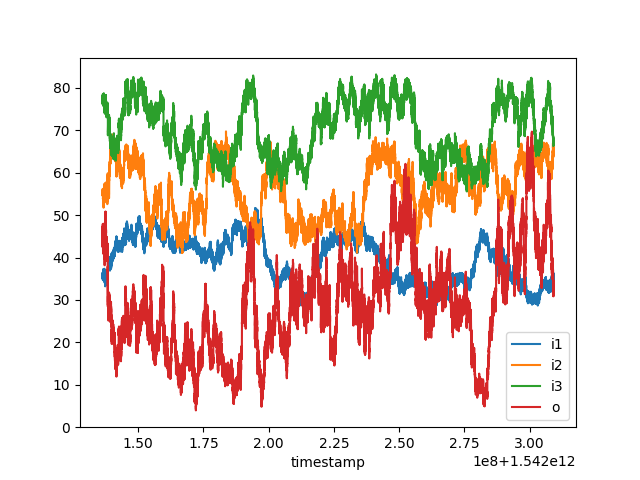

In [135]:
%matplotlib notebook
df[:int((48/60) * len(df))].plot(x="timestamp")

In [136]:
df = df.rename(index=str, columns={
    "i1": "abc_temp",
    "i2": "abc_pressure",
    "i3": "abc_rpm",
    "o": "abc_production_rate",
})

<IPython.core.display.Javascript object>


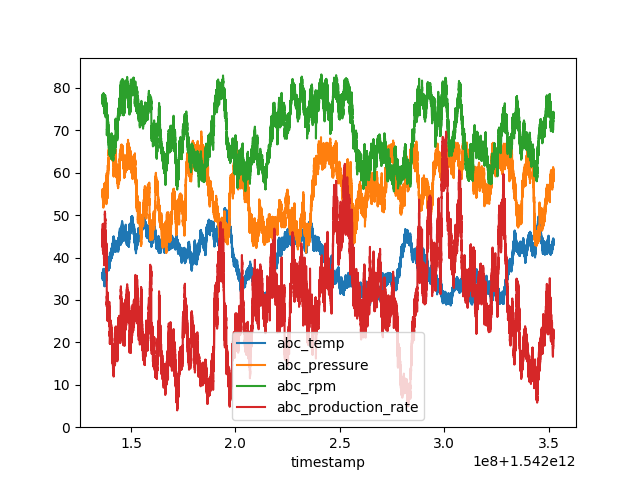

In [137]:
df.plot(x="timestamp")

In [151]:
timeseries.delete_time_series(name="abc_temp")
timeseries.delete_time_series(name="abc_pressure")
timeseries.delete_time_series(name="abc_rpm")
timeseries.delete_time_series(name="abc_production_rate")
timeseries.delete_time_series(name="abc_predicted_production_rate")

{}

In [152]:
timeseries.post_time_series(time_series=[
    timeseries.TimeSeries(name="abc_temp"),
    timeseries.TimeSeries(name="abc_pressure"),
    timeseries.TimeSeries(name="abc_rpm"),
    timeseries.TimeSeries(name="abc_production_rate"),
    timeseries.TimeSeries(name="abc_predicted_production_rate"),
])

{}

In [153]:
ts_ids = {}
for ts in timeseries.get_timeseries(prefix="abc_").to_json():
    ts_ids[ts["name"]] = ts["id"]
ts_ids

{'abc_predicted_production_rate': 5337149581566319,
 'abc_pressure': 7190281092748400,
 'abc_production_rate': 7229759307103505,
 'abc_rpm': 3289666226605573,
 'abc_temp': 5795389358768273}

In [175]:
timeseries.post_datapoints_frame(df)

{}

In [178]:
from cognite.data_transfer_service import DataSpec, TimeSeriesDataSpec, DataTransferService, TimeSeries
data_spec = DataSpec(time_series_data_specs=[
    TimeSeriesDataSpec(aggregates=["avg"], granularity="1s", start="48h-ago", end=int(time()*1000)+12*3600*1000, time_series=[
        TimeSeries(id=id) for id in ts_ids.values()
    ])
])
dts = DataTransferService(data_spec)
df2 = dts.get_dataframe()

<IPython.core.display.Javascript object>


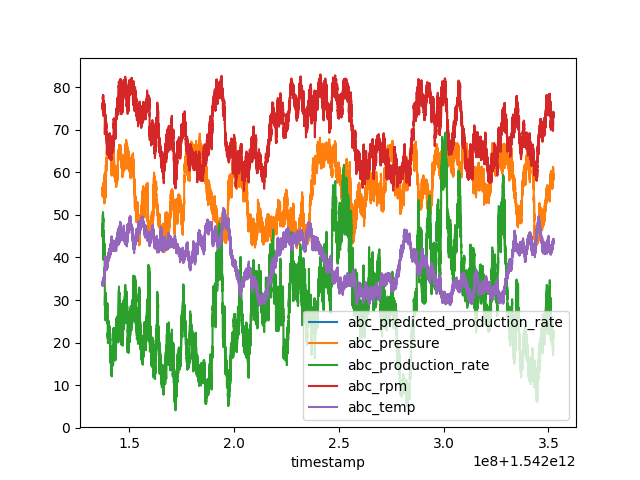

In [179]:
df2.plot(x="timestamp")

In [ ]:
len(df2)

In [ ]:
len(df)

In [138]:
from sklearn.ensemble import RandomForestRegressor

In [145]:
r = RandomForestRegressor(n_estimators=10, min_samples_split=100)

In [146]:
X = df[["abc_temp", "abc_pressure", "abc_rpm"]].as_matrix()
y = df["abc_production_rate"].as_matrix()

/Users/nils/.local/share/virtualenvs/cognite-sdk-python-81CN61_m/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/nils/.local/share/virtualenvs/cognite-sdk-python-81CN61_m/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [147]:
up_to = int(len(X)*0.8)
r.fit(X[:up_to], y[:up_to])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=100,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [84]:
import pickle
with open("lol.pickle", "wb") as f:
    pickle.dump(r, f)

In [148]:
y_hat = r.predict(X)

In [149]:
df3 = pd.DataFrame(df["timestamp"].as_matrix(), columns=["timestamp"])
df3["y"] = y
df3["y_hat"] = y_hat

/Users/nils/.local/share/virtualenvs/cognite-sdk-python-81CN61_m/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


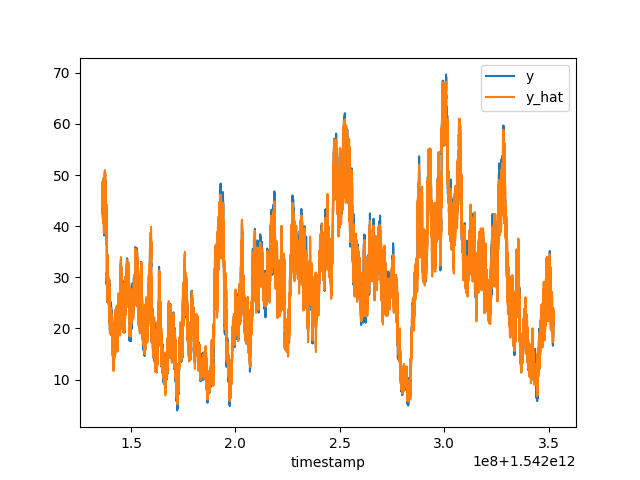

In [150]:
df3.plot(x="timestamp")

In [ ]:
from cognite.data_transfer_service import DataSpec, TimeSeriesDataSpec, DataTransferService, TimeSeries
data_spec = DataSpec(time_series_data_specs=[
    TimeSeriesDataSpec(
        aggregates=["avg"],
        granularity="1s",
        start=int(time()*1000),
        end=int(time()*1000)+1*3600*1000,
        time_series=[
            TimeSeries(id=id) for id in ts_ids.values()
        ]
    )
])
dts = DataTransferService(data_spec)
df2 = dts.get_dataframe()

In [ ]:
df2

In [ ]:
timeseries.post_time_series(time_series=[timeseries.TimeSeries(name="abc_predicted_production_rate")])

In [ ]:
timeseries.get_timeseries(prefix="abc").to_json()

<IPython.core.display.Javascript object>


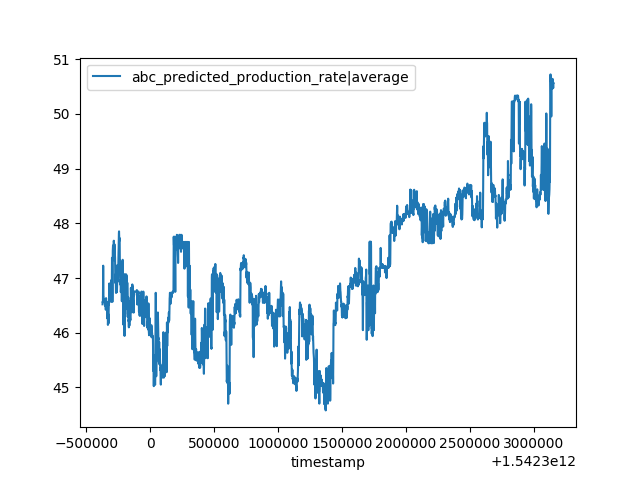

In [14]:
%matplotlib notebook
lol = timeseries.get_datapoints_frame(time_series=["abc_predicted_production_rate"], start="1h-ago", aggregates=["avg"], granularity="1s")
lol.plot(x="timestamp")

In [182]:
from cognite.v05 import files
from tempfile import NamedTemporaryFile

In [188]:
with NamedTemporaryFile("w") as f:
    f.write("haha")
    file_path = f.name
    f.flush()
    files.upload_file(file_path=file_path, file_name="megalulz3", content_type="application/text")

In [206]:
files.list_files(name="plzhelpme").to_json()

[{'id': 1252163000410206,
  'fileName': 'plzhelpme',
  'uploaded': True,
  'uploadedAt': 1542315927575,
  'createdTime': 1542315927018,
  'lastUpdatedTime': 1542315927575}]

In [207]:
files.download_file(id=1252163000410206)

'https://storage.googleapis.com/cognite-storage/4976500668260620/1252163000410206/plzhelpme?GoogleAccessId=cloud-storage@cognitedata.iam.gserviceaccount.com&Expires=1542315965&Signature=RV4GqAZGKaTBGil8vziI21flkuLzQV4axz3e9fYDll1f3SseHFZq1s52y5HmDzTAJCGl1JstzWXwYP3eRQRNSZPF4R5RNOq6TIBtu5tQBl05HvDF2jKH2m3yOk79cZ3uVcT72cNRKDFTYYiwc0uzSFJW0KsMgSQWf9e8zECjgC%2FwHxRAyRXStIdhukEy8pZyhT%2FaxaxNa1eRvr4Hmbi4VYTuNhR9c%2BvQYhvyxeb3SY4GRV55yiPkbc9%2F75xTNdF%2BWnIMh5hi%2BVPUOHw%2BqyNb6HpoKLahhwcgby%2B6XqKp4XJNWgwp9HyIIyWTZbv%2FI5uDz5Chsb%2FN06lFtI1kAUajPg%3D%3D'

In [208]:
files.delete_files(file_ids=[1252163000410206])

{'deleted': [1252163000410206], 'failed': []}

In [200]:
import traceback
try:
    lol()
    print("HEI")
except Exception as e:
    print("HEISANN")
    print(traceback.format_exc())

HEISANN
Traceback (most recent call last):
  File "<ipython-input-200-a606a7fcfb4e>", line 3, in <module>
    lol()
TypeError: 'DataFrame' object is not callable



In [209]:
from cognite.v06.analytics import models

In [247]:
models.get_source_packages()

[{'isUploaded': True,
  'id': 368892103468147,
  'runtimeVersion': '0.1',
  'metadata': {},
  'project': 'mltest',
  'packageName': 'pattern_recognition_model',
  'isDeprecated': False,
  'createdTime': 1541689784546,
  'description': 'desc',
  'availableOperations': ['predict', 'train'],
  'name': 'aert'},
 {'isUploaded': False,
  'id': 592942494580684,
  'runtimeVersion': '0.1',
  'metadata': {},
  'project': 'mltest',
  'packageName': 'pattern_recognition_model',
  'isDeprecated': False,
  'createdTime': 1541171127523,
  'description': 'desc',
  'availableOperations': ['predict', 'train'],
  'name': 'cm11'},
 {'isUploaded': True,
  'id': 1747768996438407,
  'runtimeVersion': '0.1',
  'metadata': {},
  'project': 'mltest',
  'packageName': 'pattern_recognition_model',
  'isDeprecated': False,
  'createdTime': 1542270154505,
  'description': 'desc',
  'availableOperations': ['predict', 'train'],
  'name': 'ssched007'},
 {'isUploaded': True,
  'id': 1906501050106460,
  'runtimeVersion'

In [246]:
models.delete_source_package(8190197765782584)

{}